## 📓 Predicting Berry Size
#### Given that berries are our primary food source on this island, being able to predict the size of a berry before harvesting it would be incredibly useful. This would allow us to prioritize which plants to tend to for the most substantial yield. In this section, we will build predictive models to estimate berry size based on other plant features.

### Business & Data Understanding 🧠

#### The primary goal is to accurately predict the average berry_size of a plant using its other known characteristics. This involves:

- Comparing different regression models to find the most accurate one.
- Investigating if model performance improves by focusing only on edible berries.
- Deriving a simple, explicit formula for on-the-go predictions without a computer.
- Assessing the model's performance without hard-to-measure features like soil_quality

In [ ]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

In [11]:
# Load the dataset & convert to dataframe
df = pd.read_json("../data/complete.json")

# Set plot style
sns.set_style("whitegrid")

print(df.head())


        age  leaf_size berry_colour  berry_size  leaf_shape petal_colour  \
0  9.795552  16.083941         blue    8.734281       ovate         pink   
1  8.596144  17.515386         blue   10.270547  lanceolate        white   
2  9.446874  15.677807         blue    7.777643  lanceolate        white   
3  7.342407  13.285620       purple    8.435157       ovate        white   
4  8.103198  14.996667       purple    8.351162       ovate        white   

   petal_size      height  edible  soil_quality              species  
0    1.962667  397.119296   False      3.362384  berrius delphinorum  
1    5.170076  299.475406    True      5.948337       berrius actius  
2    3.996334  192.531378    True      4.888970       berrius actius  
3    2.483346  127.481779   False      3.221025       berrius codiae  
4    2.427108  154.036470   False      3.199550       berrius codiae  


Initial Data Understanding

--- Data Overview (Plants with Berries Only) ---
<class 'pandas.core.frame.DataFrame'>
Index: 438 entries, 0 to 499
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           438 non-null    float64
 1   leaf_size     438 non-null    float64
 2   berry_colour  438 non-null    object 
 3   berry_size    438 non-null    float64
 4   leaf_shape    438 non-null    object 
 5   petal_colour  438 non-null    object 
 6   petal_size    438 non-null    float64
 7   height        438 non-null    float64
 8   edible        438 non-null    bool   
 9   soil_quality  438 non-null    float64
 10  species       438 non-null    object 
dtypes: bool(1), float64(6), object(4)
memory usage: 38.1+ KB
None


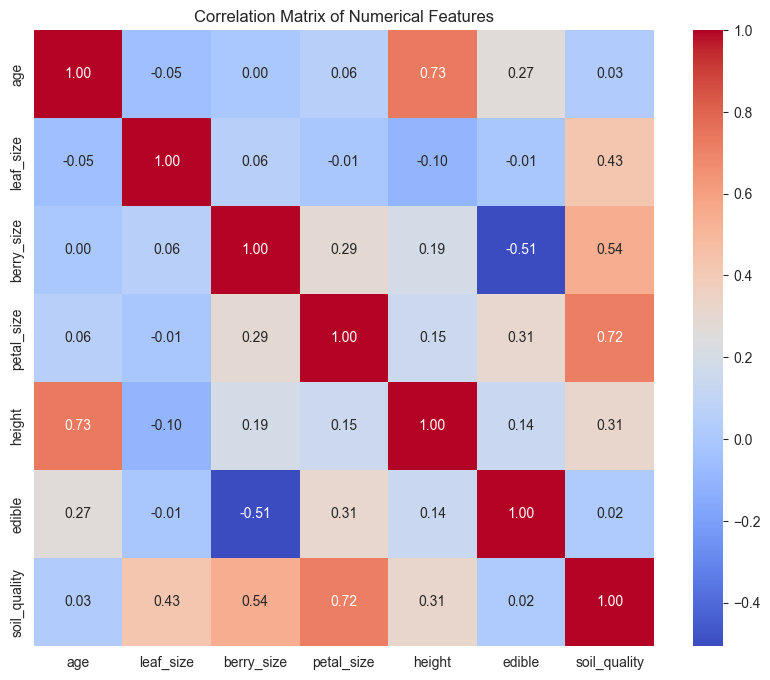

In [12]:
# Drop rows where berry_size is 0, as these are likely plants without berries yet.
df_berries = df[df['berry_size'] > 0].copy()

print("--- Data Overview (Plants with Berries Only) ---")
print(df_berries.info())

# Visualize correlations between numerical features and our target, 'berry_size'
plt.figure(figsize=(10, 8))
corr_matrix = df_berries.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()


### Data Preparation ⚙️

Predicting berry size with different methods

In [16]:
# Define features (X) and target (y)
X = df.drop('berry_size', axis=1)
y = df['berry_size']


# Identify feature types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['berry_colour', 'leaf_shape', 'petal_colour', 'species']

# The 'edible' column is boolean, we'll treat it as numeric (0/1)
if 'edible' not in numerical_features:
    numerical_features.append('edible')

print(f"Numerical features: {numerical_features}")


# Create a preprocessing pipeline
# OneHotEncoder for categorical variables, StandardScaler for numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Numerical features: ['age', 'leaf_size', 'petal_size', 'height', 'soil_quality', 'edible']


### Modeling and Evaluation 🛠️

Train & evaluate two different models. We'll use R-squared (R²) and Mean Squared Error (MSE) as our primary evaluation metrics.

R-squared (R²): Represents the proportion of the variance in the dependent variable that is predictable from the independent variable(s). A score closer to 1 is better.

Mean Squared Error (MSE): Measures the average of the squares of the errors. A lower value is better.


--- Full Dataset Prediction ---

Linear Regression Performance:
  R-squared: 0.7970
  Mean Squared Error: 0.9207

Random Forest Regressor Performance:
  R-squared: 0.7492
  Mean Squared Error: 1.1374


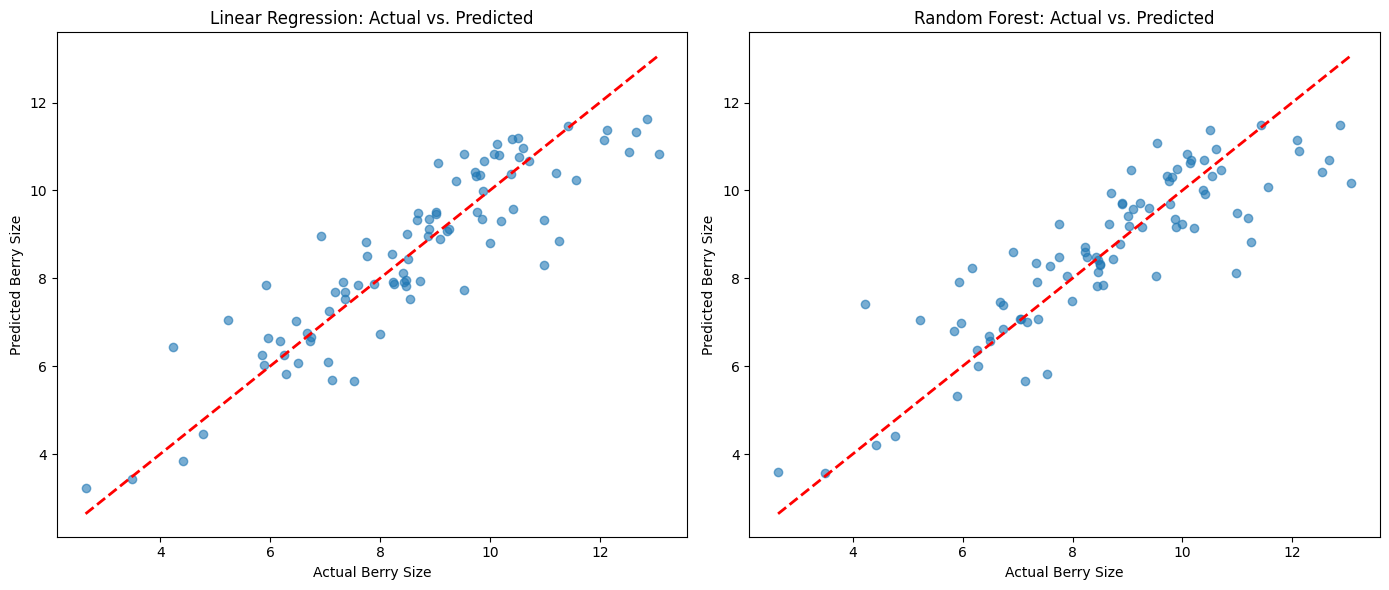

In [6]:
# --- Model 1: Linear Regression ---
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# --- Model 2: Random Forest Regressor ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

# --- Evaluation ---
print("--- Full Dataset Prediction ---")
print("\nLinear Regression Performance:")
print(f"  R-squared: {r2_score(y_test, y_pred_lr):.4f}")
print(f"  Mean Squared Error: {mean_squared_error(y_test, y_pred_lr):.4f}")

print("\nRandom Forest Regressor Performance:")
print(f"  R-squared: {r2_score(y_test, y_pred_rf):.4f}")
print(f"  Mean Squared Error: {mean_squared_error(y_test, y_pred_rf):.4f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
plt.title('Linear Regression: Actual vs. Predicted')
plt.xlabel('Actual Berry Size')
plt.ylabel('Predicted Berry Size')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
plt.title('Random Forest: Actual vs. Predicted')
plt.xlabel('Actual Berry Size')
plt.ylabel('Predicted Berry Size')

plt.tight_layout()
plt.show()


Analysis

#### 3.2: Predicting for Edible Berries Only
Now, let's focus only on the berries we care about for survival: the edible ones. We will repeat the prediction process using only the subset of data where edible is True.

In [17]:
# --- Predicting for Edible Berries Only ---

# Filter for edible berries
df_edible = df[df['edible'] == True].copy()

# Define features and target for the edible subset
y_edible = df_edible['berry_size']
X_edible = df_edible.drop('berry_size', axis=1)

# Split the edible data
X_train_ed, X_test_ed, y_train_ed, y_test_ed = train_test_split(X_edible, y_edible, test_size=0.2, random_state=42)

# --- Retrain and Evaluate Models on Edible Data ---

# Linear Regression on edible data
lr_pipeline.fit(X_train_ed, y_train_ed)
y_pred_lr_ed = lr_pipeline.predict(X_test_ed)

# Random Forest on edible data
rf_pipeline.fit(X_train_ed, y_train_ed)
y_pred_rf_ed = rf_pipeline.predict(X_test_ed)

# --- Evaluation on Edible Subset ---
print("\n--- Edible Berries Only Prediction ---")
print("\nLinear Regression Performance (Edible):")
print(f"  R-squared: {r2_score(y_test_ed, y_pred_lr_ed):.4f}")
print(f"  Mean Squared Error: {mean_squared_error(y_test_ed, y_pred_lr_ed):.4f}")

print("\nRandom Forest Regressor Performance (Edible):")
print(f"  R-squared: {r2_score(y_test_ed, y_pred_rf_ed):.4f}")
print(f"  Mean Squared Error: {mean_squared_error(y_test_ed, y_pred_rf_ed):.4f}")



--- Edible Berries Only Prediction ---

Linear Regression Performance (Edible):
  R-squared: 0.8617
  Mean Squared Error: 1.4060

Random Forest Regressor Performance (Edible):
  R-squared: 0.8473
  Mean Squared Error: 1.5523


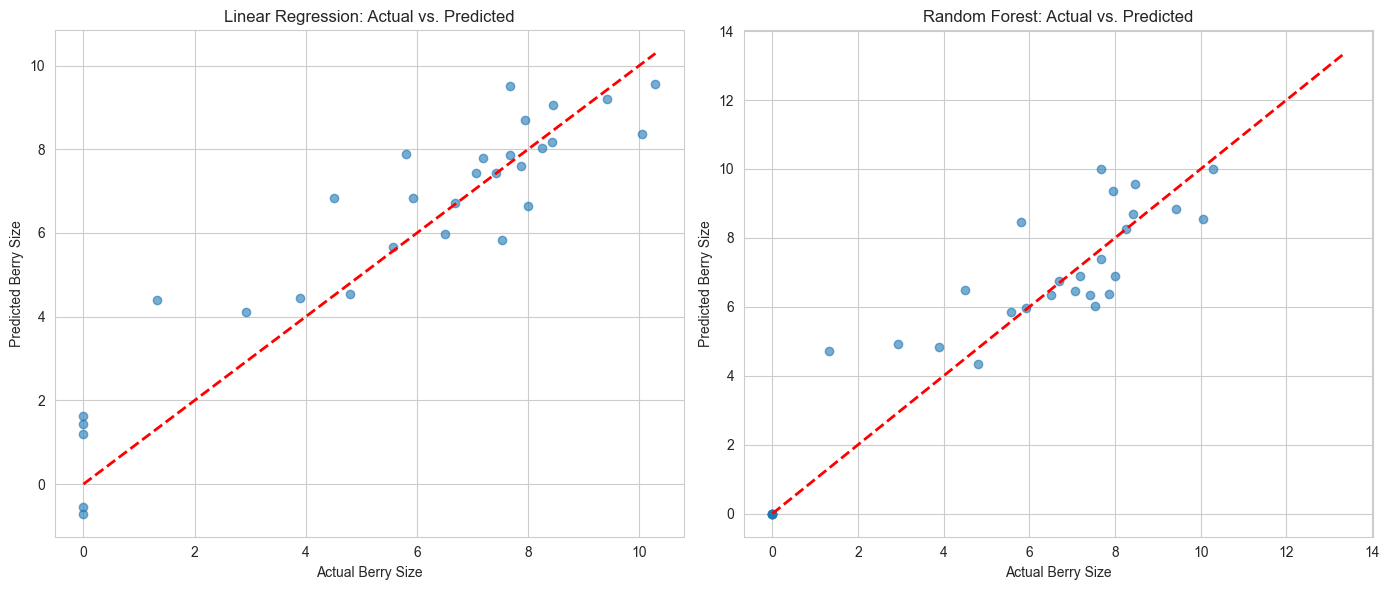

In [21]:
# Visualize the predictions vs actual values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_ed, y_pred_lr_ed, alpha=0.6)
plt.plot([y_test_ed.min(), y_test_ed.max()], [y_test_ed.min(), y_test_ed.max()], '--', color='red', lw=2)
plt.title('Linear Regression: Actual vs. Predicted')
plt.xlabel('Actual Berry Size')
plt.ylabel('Predicted Berry Size')

plt.subplot(1, 2, 2)
plt.scatter(y_test_ed, y_pred_rf_ed, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
plt.title('Random Forest: Actual vs. Predicted')
plt.xlabel('Actual Berry Size')
plt.ylabel('Predicted Berry Size')

plt.tight_layout()
plt.show()

Analysis:


3.3: Deriving an Explicit Expression for Berry Size
To create a predictor that can be used in the wilderness without a computer, we need a simple, explicit formula. A linear regression model is perfect for this. We will use the statsmodels library, which provides a detailed summary including the coefficients for each feature.
We will build this model on the edible berries dataset since that is our focus for survival.

In [22]:
# --- Deriving a Field-Ready Formula ---
X_formula = df_berries.drop('berry_size', axis=1)
y_formula = df_berries['berry_size']

# Manually encode categorical variables for the formula
X_formula_encoded = pd.get_dummies(X_formula, columns=categorical_features, drop_first=True)
X_formula_encoded['edible'] = X_formula_encoded['edible'].astype(int)

# Add a constant for the intercept term
X_sm = sm.add_constant(X_formula_encoded)

# Fit the OLS model
model = sm.OLS(y_formula, X_sm).fit()

print("\n--- Linear Regression Model Summary (for Formula Derivation) ---")
print(model.summary())

# --- Construct the formula string ---
print("\n--- Explicit Formula for Berry Size ---")
formula = f"Berry Size = {model.params['const']:.2f}"
for feature, coef in model.params.items():
    if feature != 'const':
        sign = "+" if coef >= 0 else "-"
        formula += f" {sign} {abs(coef):.2f} * ({feature})"
print(formula)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

#### 3.4: Predicting with a Subset of Features
Assessing soil quality in the wild can be difficult. Therefore, it would be beneficial to have a model that can predict berry size without this feature. Let's retrain our best model (Random Forest) on the edible berries dataset, but exclude soil_quality.

In [23]:
# --- Predicting without Soil Quality ---

# Drop soil_quality from the feature set
X_edible_no_soil = df_edible.drop(['berry_size', 'soil_quality'], axis=1)
y_edible_no_soil = df_edible['berry_size']

# Identify new feature sets
categorical_features_ns = ['berry_colour', 'leaf_shape', 'petal_colour', 'species', 'edible']
numerical_features_ns = ['age', 'leaf_size', 'petal_size', 'height']

# Create a new preprocessor without soil_quality
preprocessor_ns = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_ns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_ns)
    ])

# Create the pipeline
rf_pipeline_ns = Pipeline(steps=[('preprocessor', preprocessor_ns),
                                 ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# Split, train, and evaluate
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X_edible_no_soil, y_edible_no_soil, test_size=0.2, random_state=42)
rf_pipeline_ns.fit(X_train_ns, y_train_ns)
y_pred_rf_ns = rf_pipeline_ns.predict(X_test_ns)

# --- Evaluation without Soil Quality ---
print("\n--- Random Forest Performance (Edible, No Soil Quality) ---")
print(f"  R-squared: {r2_score(y_test_ns, y_pred_rf_ns):.4f}")
print(f"  Mean Squared Error: {mean_squared_error(y_test_ns, y_pred_rf_ns):.4f}")



--- Random Forest Performance (Edible, No Soil Quality) ---
  R-squared: 0.8456
  Mean Squared Error: 1.5693
